# Import Library & Load Data

In [74]:
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
import matplotlib
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTENC
import pickle

# NSCH Dataset

In [75]:
import pyreadstat

In [83]:
nsch, meta = pyreadstat.read_sas7bdat('nsch_2020_topical.sas7bdat')

In [84]:
features = ['K2Q31A','SC_AGE_YEARS', 'SC_SEX', 'MOMAGE', 'ALLERGIES', 'ACE9', 'SC_RACE_R', 
            'BIRTHWT', 'ACE3', 'ACE4', 'ACE5', 'FPL_I1', 'BIRTHWT_VL', 'HOURSLEEP']

In [85]:
nsch = nsch[features]

In [86]:
nsch['K2Q31A'] = nsch['K2Q31A'].replace(2.0, 0.0)
nsch['SC_SEX'] = nsch['SC_SEX'].replace(2.0, 0.0)
nsch['ALLERGIES'] = nsch['ALLERGIES'].replace(2.0, 0.0)
nsch['ACE9'] = nsch['ACE9'].replace(2.0, 0.0)
nsch['ACE3'] = nsch['ACE3'].replace(2.0, 0.0)
nsch['ACE4'] = nsch['ACE4'].replace(2.0, 0.0)
nsch['ACE5'] = nsch['ACE5'].replace(2.0, 0.0)
nsch['BIRTHWT_VL'] = nsch['BIRTHWT_VL'].replace(2.0, 0.0)

In [87]:
nsch = nsch.dropna()
nsch

,K2Q31A,SC_AGE_YEARS,SC_SEX,MOMAGE,ALLERGIES,ACE9,SC_RACE_R,BIRTHWT,ACE3,ACE4,ACE5,FPL_I1,BIRTHWT_VL,HOURSLEEP
1,0.0,14.0,0.0,31.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,400.0,0.0,4.0
3,0.0,15.0,0.0,29.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,143.0,0.0,4.0
4,0.0,16.0,0.0,24.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,400.0,0.0,4.0
5,0.0,17.0,0.0,24.0,1.0,0.0,1.0,3.0,1.0,0.0,0.0,90.0,0.0,4.0
6,0.0,9.0,0.0,30.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,333.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42772,1.0,13.0,1.0,21.0,1.0,0.0,1.0,3.0,1.0,0.0,0.0,187.0,0.0,3.0
42773,0.0,7.0,1.0,38.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,298.0,0.0,4.0
42774,1.0,14.0,0.0,39.0,1.0,1.0,1.0,3.0,1.0,0.0,0.0,314.0,0.0,4.0
42775,0.0,10.0,0.0,30.0,1.0,0.0,7.0,3.0,0.0,0.0,0.0,400.0,0.0,4.0


In [88]:
raw = nsch.to_numpy()

In [89]:
X = raw[:,1:]
X.shape    #(Num of Samples, Num of Features)

(27513, 13)

In [90]:
y = raw[:,0]
y = y.astype('int')
y.shape    #(Num of Samples)

(27513,)

# ABCD dataset

In [13]:
df = pd.read_csv('./data/ADHD_data.csv')
mean_BMI=df['BMI'].mean()
mean_income=round(df['demo_comb_income_v2'].mean())
mean_sleep=df['fit_ss_sleepperiod_minutes'].mean()
mean_screen=df['avg_screen'].mean()
df['BMI'].fillna(value=mean_BMI, inplace=True)
df['demo_comb_income_v2'].fillna(value=mean_income, inplace=True)
df['fit_ss_sleepperiod_minutes'].fillna(value=mean_sleep, inplace=True)
df['avg_screen'].fillna(value=mean_screen, inplace=True)
df['drug_used'].fillna(value=0.0, inplace=True)
print(df.head())
raw = df.to_numpy()

         subjectkey  score_sum        BMI  fit_ss_sleepperiod_minutes  \
0      NDARMC003PZF         37  17.849609                  458.000000   
1  NDAR_INV019DXLU4         24  20.457187                  440.318182   
2  NDAR_INV021403LF         26  21.107358                  449.023810   
3  NDAR_INV042UJKFB         19  19.866220                  451.000000   
4  NDAR_INV05T64PXD         35  22.884619                  433.538462   

   demo_comb_income_v2  avg_screen  drug_used  
0                  2.0   12.714286        0.0  
1                  9.0    4.071429        0.0  
2                  7.0    3.214286        0.0  
3                  9.0    7.750000        0.0  
4                  7.0    2.178571        0.0  


In [14]:
X = raw[:,2:]
X.shape    #(Num of Samples, Num of Features)

(432, 5)

In [15]:
y = raw[:,1]
y = y.astype('int')
y.shape    #(Num of Samples)

(432,)

# Embedding, change to classification

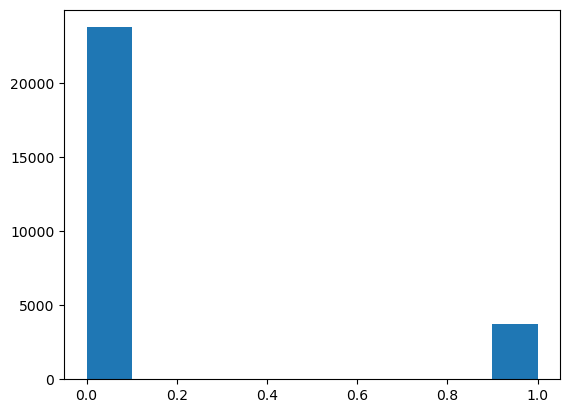

In [91]:
plt.hist(y)
plt.show()

### 1. Threshold - [ y_t ]

In [17]:
threshold=60
over_t = []
for i in y:
    if i>threshold:
        over_t.append(i)
print(len(over_t))
print(over_t)

41
[69, 61, 63, 62, 64, 61, 64, 65, 67, 63, 64, 65, 73, 65, 64, 68, 72, 68, 62, 71, 66, 61, 75, 61, 69, 62, 63, 69, 71, 61, 66, 65, 72, 64, 65, 66, 61, 65, 70, 63, 64]


In [18]:
y_t = np.asarray([i>threshold for i in y]).astype('int')
print(y_t)

[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0]


### 2. Top K% - [ y_k ]

In [19]:
k = 10
cnt = int(k/100*len(y))
temp = np.sort(y)[::-1]
temp = temp[:cnt]
min_val = temp[-1]
print(min_val)

60


In [20]:
y_k = np.asarray([i>=min_val for i in y]).astype('int')
print(y_k)

[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0]


### 3. Decide what to use

In [21]:
#y = y_t
y = y_k

# Find Hyperparam & Train

In [40]:
smote = SMOTENC(random_state=1234, categorical_features=[4], k_neighbors=3)

In [41]:
print(sum(y)/len(y))

0.09953703703703703


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y)

In [43]:
len(y_train)

388

In [44]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [45]:
len(y_train)

698

In [46]:
params = {
    'max_depth': [2, 3, 4, 5, 6, 7],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]
}

In [47]:
clf = RandomForestClassifier()
grid_tree = GridSearchCV(clf, param_grid=params, cv=3, refit=True, scoring='recall')
grid_tree.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='recall')

In [48]:
em = grid_tree.best_estimator_
print(em)

RandomForestClassifier(max_depth=7, min_samples_split=4)


In [51]:
pickle.dump(em, open("model.sav", 'wb'))

# Prediction & Metrics

In [49]:
prediction = em.predict(X_test)
confidence = em.predict_proba(X_test)
score = em.score(X_test, y_test)
print("Accuracy: "+str(score))

Accuracy: 0.75


In [50]:
precision = precision_score(y_test, prediction)
recall = recall_score(y_test, prediction)
print("Precision: "+str(precision))
print("Recall: "+str(recall))

Precision: 0.0
Recall: 0.0


In [299]:
print(y_test)

[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0]


In [300]:
print(prediction)

[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0]
